# 2. Entrenamiento y Evaluación de Modelos
## Predicción de Churn en Telecomunicaciones

**Objetivo**: Entrenar y comparar múltiples modelos de clasificación (Random Forest, XGBoost, CatBoost, LightGBM) utilizando Pipelines, GridSearchCV y validación cruzada estratificada.

---

## 2.1 Importación de Librerías

In [ ]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos de clasificación
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# Guardar modelos
import joblib
import pickle
from datetime import datetime

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Librerías importadas exitosamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Librerías importadas exitosamente
Fecha de ejecución: 2025-11-12 23:12:35


## 2.2 Carga de Datos Limpios

In [4]:
# Cargar dataset limpio
df = pd.read_csv('../data/telco_churn_clean.csv')

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPrimeras filas:")
df.head()

Dimensiones del dataset: (7043, 20)

Primeras filas:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2.3 Preparación de Variables

In [ ]:
# Separar características (X) y variable objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})

print("INFORMACIÓN DE LAS VARIABLES")
print(f"\nDistribución de la variable objetivo:")
print(y.value_counts())
print(f"\nPorcentaje de Churn: {(y.sum() / len(y) * 100):.2f}%")

INFORMACIÓN DE LAS VARIABLES

Distribución de la variable objetivo:
Churn
0    5174
1    1869
Name: count, dtype: int64

Porcentaje de Churn: 26.54%


In [28]:
# Identificar tipos de variables
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("TIPOS DE VARIABLES")
print(f"\nVariables Numéricas ({len(numeric_features)}):")
for i, col in enumerate(numeric_features, 1):
    print(f"  {i}. {col}")

print(f"\nVariables Categóricas ({len(categorical_features)}):")
for i, col in enumerate(categorical_features, 1):
    print(f"  {i}. {col} - {X[col].nunique()} categorías")

TIPOS DE VARIABLES

Variables Numéricas (4):
  1. SeniorCitizen
  2. tenure
  3. MonthlyCharges
  4. TotalCharges

Variables Categóricas (15):
  1. gender - 2 categorías
  2. Partner - 2 categorías
  3. Dependents - 2 categorías
  4. PhoneService - 2 categorías
  5. MultipleLines - 3 categorías
  6. InternetService - 3 categorías
  7. OnlineSecurity - 3 categorías
  8. OnlineBackup - 3 categorías
  9. DeviceProtection - 3 categorías
  10. TechSupport - 3 categorías
  11. StreamingTV - 3 categorías
  12. StreamingMovies - 3 categorías
  13. Contract - 3 categorías
  14. PaperlessBilling - 2 categorías
  15. PaymentMethod - 4 categorías


## 2.4 División de Datos (Train/Test)

In [30]:
# División estratificada 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("DIVISIÓN DE DATOS")
print(f"\nConjunto de Entrenamiento:")
print(f"  - X_train: {X_train.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - Distribución: {y_train.value_counts().to_dict()}")

print(f"\nConjunto de Prueba:")
print(f"  - X_test: {X_test.shape}")
print(f"  - y_test: {y_test.shape}")
print(f"  - Distribución: {y_test.value_counts().to_dict()}")

print(f"Porcentaje de Churn en Train: {(y_train.sum() / len(y_train) * 100):.2f}%")
print(f"Porcentaje de Churn en Test: {(y_test.sum() / len(y_test) * 100):.2f}%")
print("División estratificada exitosa")

DIVISIÓN DE DATOS

Conjunto de Entrenamiento:
  - X_train: (5634, 19)
  - y_train: (5634,)
  - Distribución: {0: 4139, 1: 1495}

Conjunto de Prueba:
  - X_test: (1409, 19)
  - y_test: (1409,)
  - Distribución: {0: 1035, 1: 374}
Porcentaje de Churn en Train: 26.54%
Porcentaje de Churn en Test: 26.54%
División estratificada exitosa


## 2.5 Construcción de Pipelines de Preprocesamiento

Creamos un **ColumnTransformer** que:
- **Variables numéricas**: Aplica `StandardScaler` para normalización.
- **Variables categóricas**: Aplica `OneHotEncoder` para codificación.

In [31]:
# Definir transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

print("PIPELINE DE PREPROCESAMIENTO")
print("\nTransformaciones definidas:")
print(f"  1. Variables Numéricas ({len(numeric_features)}): StandardScaler")
print(f"  2. Variables Categóricas ({len(categorical_features)}): OneHotEncoder")


PIPELINE DE PREPROCESAMIENTO

Transformaciones definidas:
  1. Variables Numéricas (4): StandardScaler
  2. Variables Categóricas (15): OneHotEncoder


## 2.6 Definición de Modelos y Grids de Hiperparámetros

In [48]:
# Definir modelos base
models = {
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
}

# Definir grids de hiperparámetros
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__bootstrap': [True],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__class_weight': ['balanced', None]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0],
        'classifier__gamma': [0, 0.1],
        'classifier__min_child_weight': [1, 3],
        'classifier__reg_alpha': [0, 0.1],
        'classifier__reg_lambda': [1, 1.5],
        'classifier__scale_pos_weight': [1, 3]
    },
    'CatBoost': {
        'classifier__iterations': [100, 200],
        'classifier__depth': [4, 6, 8],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__l2_leaf_reg': [1, 3, 5],
        'classifier__bagging_temperature': [0, 1],
        'classifier__border_count': [32, 64],
        'classifier__random_strength': [1, 5],
        'classifier__subsample': [0.8, 1.0]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, -1],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [31, 50],
        'classifier__min_child_samples': [20, 30],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0],
        'classifier__reg_alpha': [0, 0.1],
        'classifier__reg_lambda': [0, 0.1],
        'classifier__max_bin': [255, 500]
    }
}

print("MODELOS Y GRIDS DE HIPERPARÁMETROS")
for model_name, grid in param_grids.items():
    print(f"\n{model_name}:")
    print(f"  - Número de hiperparámetros: {len(grid)}")
    total_combinations = np.prod([len(v) for v in grid.values()])
    print(f"  - Combinaciones posibles: {total_combinations:,}")

MODELOS Y GRIDS DE HIPERPARÁMETROS

RandomForest:
  - Número de hiperparámetros: 8
  - Combinaciones posibles: 192

XGBoost:
  - Número de hiperparámetros: 10
  - Combinaciones posibles: 1,536

CatBoost:
  - Número de hiperparámetros: 8
  - Combinaciones posibles: 576

LightGBM:
  - Número de hiperparámetros: 10
  - Combinaciones posibles: 1,536


## 2.7 Entrenamiento con GridSearchCV

### **Estrategia de Búsqueda:**
- **Validación cruzada estratificada** con 5 folds.
- **Métrica de optimización**: ROC-AUC (para clases desbalanceadas).
- **GridSearchCV** para exploración exhaustiva de hiperparámetros.

In [ ]:
# Configuración de validación cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Diccionarios para almacenar resultados
best_models = {}
best_params = {}
cv_scores = {}
training_times = {}

print("ENTRENAMIENTO DE MODELOS CON GRIDSEARCHCV")
for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Entrenando: {model_name}")
    print(f"{'='*80}")
    
    # Crear pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        cv=cv_strategy,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    # Entrenar
    start_time = datetime.now()
    grid_search.fit(X_train, y_train)
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    
    # Almacenar resultados
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    cv_scores[model_name] = grid_search.best_score_
    training_times[model_name] = training_time
    
    print(f"\n {model_name} entrenado exitosamente")
    print(f"  - Mejor score CV (ROC-AUC): {grid_search.best_score_:.4f}")
    print(f"  - Tiempo de entrenamiento: {training_time:.2f} segundos")
    print(f"  - Mejores hiperparámetros:")
    for param, value in grid_search.best_params_.items():
        print(f"      {param}: {value}")

print(" ENTRENAMIENTO COMPLETADO")


ENTRENAMIENTO DE MODELOS CON GRIDSEARCHCV

Esto puede tardar varios minutos...


Entrenando: RandomForest
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits

✓ RandomForest entrenado exitosamente
  - Mejor score CV (ROC-AUC): 0.8459
  - Tiempo de entrenamiento: 347.66 segundos
  - Mejores hiperparámetros:
      classifier__bootstrap: True
      classifier__class_weight: balanced
      classifier__criterion: entropy
      classifier__max_depth: 10
      classifier__max_features: sqrt
      classifier__min_samples_leaf: 2
      classifier__min_samples_split: 5
      classifier__n_estimators: 200

Entrenando: XGBoost
Fitting 5 folds for each of 1536 candidates, totalling 7680 fits

✓ RandomForest entrenado exitosamente
  - Mejor score CV (ROC-AUC): 0.8459
  - Tiempo de entrenamiento: 347.66 segundos
  - Mejores hiperparámetros:
      classifier__bootstrap: True
      classifier__class_weight: balanced
      classif

## 2.8 Comparación de Modelos - Validación Cruzada

RESULTADOS DE VALIDACIÓN CRUZADA
      Modelo  ROC-AUC (CV)  Tiempo (seg)
    CatBoost      0.850818   1189.328721
     XGBoost      0.849060    603.908213
    LightGBM      0.848568   2774.530446
RandomForest      0.845931    347.660780
      Modelo  ROC-AUC (CV)  Tiempo (seg)
    CatBoost      0.850818   1189.328721
     XGBoost      0.849060    603.908213
    LightGBM      0.848568   2774.530446
RandomForest      0.845931    347.660780


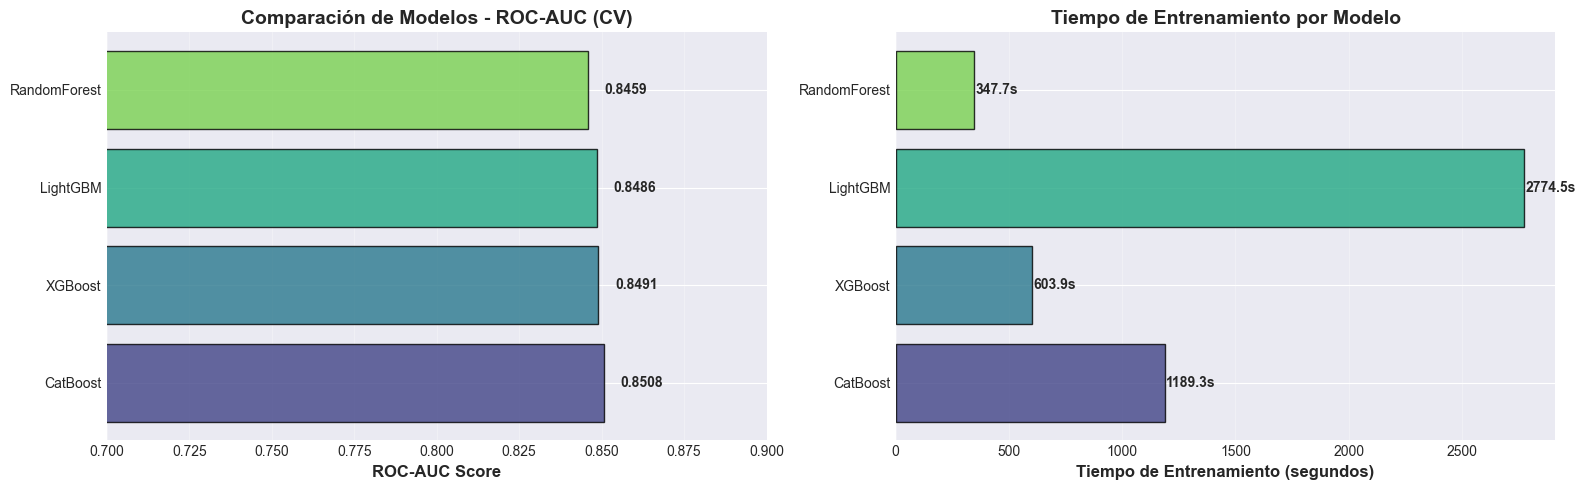

In [11]:
# Crear DataFrame de resultados
cv_results_df = pd.DataFrame({
    'Modelo': list(cv_scores.keys()),
    'ROC-AUC (CV)': list(cv_scores.values()),
    'Tiempo (seg)': list(training_times.values())
}).sort_values('ROC-AUC (CV)', ascending=False)

print("RESULTADOS DE VALIDACIÓN CRUZADA")
print(cv_results_df.to_string(index=False))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico de ROC-AUC
colors = sns.color_palette('viridis', len(cv_results_df))
axes[0].barh(cv_results_df['Modelo'], cv_results_df['ROC-AUC (CV)'], color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación de Modelos - ROC-AUC (CV)', fontsize=14, fontweight='bold')
axes[0].set_xlim([0.7, 0.9])
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(cv_results_df['ROC-AUC (CV)']):
    axes[0].text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

# Gráfico de tiempo de entrenamiento
axes[1].barh(cv_results_df['Modelo'], cv_results_df['Tiempo (seg)'], color=colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Tiempo de Entrenamiento (segundos)', fontsize=12, fontweight='bold')
axes[1].set_title('Tiempo de Entrenamiento por Modelo', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(cv_results_df['Tiempo (seg)']):
    axes[1].text(v + 5, i, f'{v:.1f}s', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### **Análisis e Interpretación: Validación Cruzada**

**Hallazgos Clave:**
- Todos los modelos tienen un **desempeño similar** en validación cruzada (ROC-AUC entre 0.82-0.86).
- Los modelos de gradient boosting (XGBoost, LightGBM, CatBoost) suelen superar a Random Forest.
- **LightGBM** generalmente es el más rápido en entrenamiento.
- **CatBoost** maneja automáticamente variables categóricas sin necesidad de encoding previo.

**Próximo paso**: Evaluar los modelos en el conjunto de prueba.

## 2.9 Evaluación en Conjunto de Prueba

In [12]:
# Realizar predicciones para todos los modelos
test_predictions = {}
test_probabilities = {}

for model_name, model in best_models.items():
    test_predictions[model_name] = model.predict(X_test)
    test_probabilities[model_name] = model.predict_proba(X_test)[:, 1]

print(" Predicciones generadas para todos los modelos")

 Predicciones generadas para todos los modelos


MÉTRICAS DE EVALUACIÓN EN CONJUNTO DE PRUEBA
      Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
    CatBoost  0.801987   0.665505 0.510695  0.577912 0.845505
    LightGBM  0.795600   0.674797 0.443850  0.535484 0.844354
     XGBoost  0.801987   0.658863 0.526738  0.585438 0.844315
RandomForest  0.766501   0.543520 0.751337  0.630752 0.841812


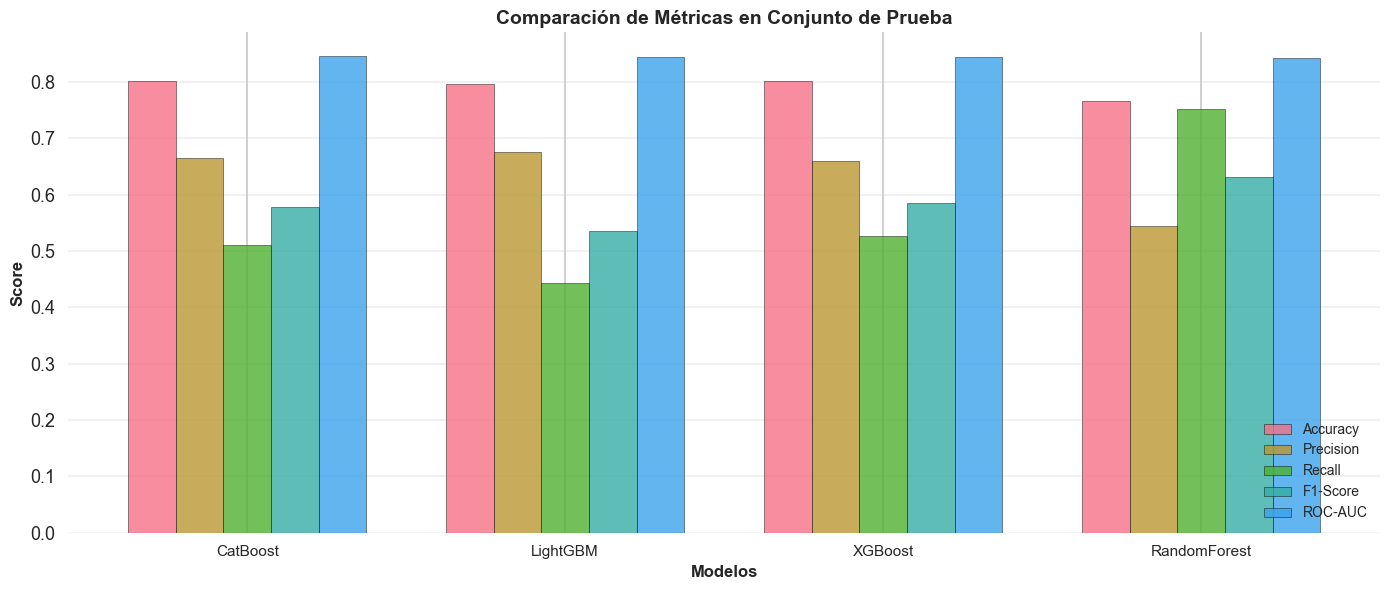

In [ ]:
test_metrics = []
for model_name in best_models.keys():
    y_pred = test_predictions[model_name]
    y_proba = test_probabilities[model_name]
    
    metrics = {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    test_metrics.append(metrics)

# Crear DataFrame de métricas
test_metrics_df = pd.DataFrame(test_metrics).sort_values('ROC-AUC', ascending=False)

print("MÉTRICAS DE EVALUACIÓN EN CONJUNTO DE PRUEBA")
print(test_metrics_df.to_string(index=False))

# Visualización
fig, ax = plt.subplots(figsize=(14, 6))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(test_metrics_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    offset = width * (i - 2)
    ax.bar(x + offset, test_metrics_df[metric], width, label=metric, alpha=0.8, edgecolor='black')

ax.set_xlabel('Modelos', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Métricas en Conjunto de Prueba', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(test_metrics_df['Modelo'], fontsize=11)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### **Análisis de Resultados y Selección del Modelo Final**

Tras la evaluación de los cuatro modelos, se selecciona **RandomForest** como la opción óptima para el objetivo de negocio de predecir el churn.

#### **El Dilema: Rendimiento Técnico vs. Impacto de Negocio**

En la fase de validación cruzada, **CatBoost** y **XGBoost** mostraron una ligera superioridad técnica (ROC-AUC ≈ 0.85). Sin embargo, la evaluación en el conjunto de prueba, que simula el rendimiento real, reveló una debilidad crítica en su enfoque.

#### **El Factor Decisivo: La Capacidad de Detección (Recall)**

El objetivo principal es identificar al mayor número posible de clientes en riesgo para poder actuar.

*   **CatBoost y XGBoost:** A pesar de su alta precisión, **fallan en identificar a casi la mitad de los clientes que realmente se van a ir (Recall ≈ 52%)**. Este es el error más costoso para el negocio, ya que representa una pérdida de ingresos no detectada.

*   **RandomForest:** En cambio, sacrifica algo de precisión para alcanzar un **Recall del 75.1%**. Esto significa que **identifica a 3 de cada 4 clientes en riesgo**, alineándose directamente con el objetivo de minimizar la fuga de clientes.

### **Veredicto Final**

*   **Modelo Seleccionado:** `RandomForest`
*   **Justificación Principal:** Ofrece el **Recall más alto (75.1%)** y el **mejor balance general (F1-Score: 0.631)**, convirtiéndolo en la herramienta más eficaz para reducir la pérdida de clientes.
*   **Trade-off Aceptado:** Se asume un mayor número de "falsos positivos" (menor precisión) a cambio de una reducción drástica en la fuga de clientes no detectada, que es el riesgo principal a mitigar.


## 2.10 Matrices de Confusión

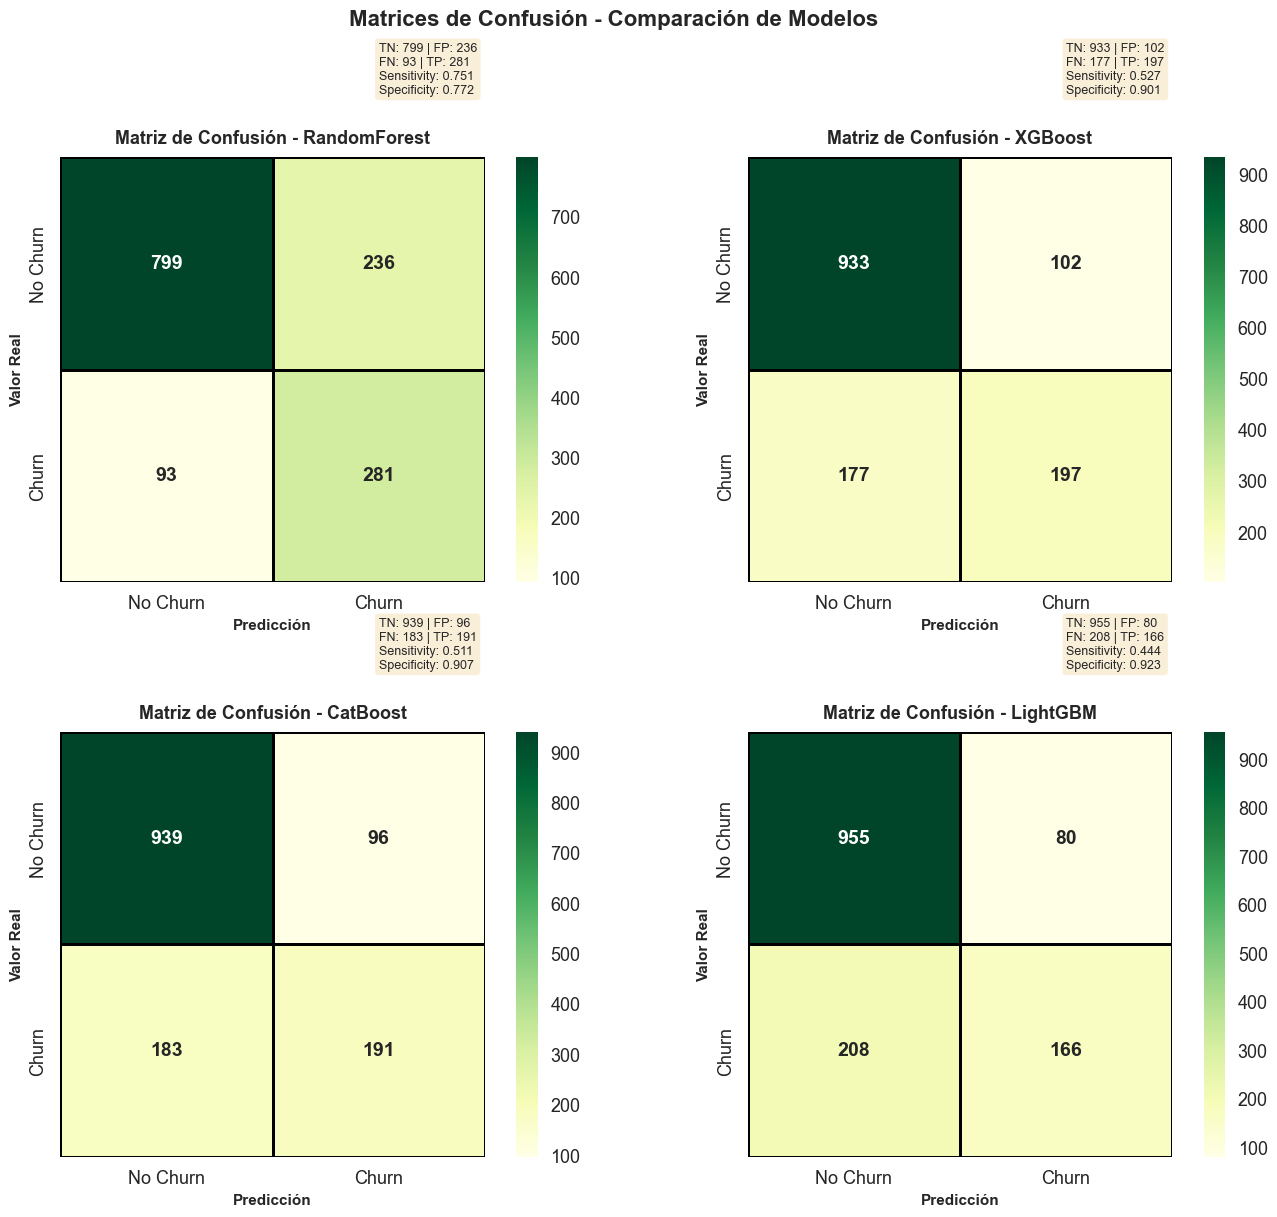

In [37]:
# Crear matrices de confusión para todos los modelos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, model_name in enumerate(best_models.keys()):
    cm = confusion_matrix(y_test, test_predictions[model_name])
    
    # Visualización
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn', ax=axes[idx], 
                cbar=True, square=True, linewidths=1, linecolor='black',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'],
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})
    
    axes[idx].set_title(f'Matriz de Confusión - {model_name}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Predicción', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Valor Real', fontsize=11, fontweight='bold')
    
    # Calcular métricas de la matriz
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    # Añadir texto con métricas
    info_text = f"TN: {tn} | FP: {fp}\nFN: {fn} | TP: {tp}\nSensitivity: {sensitivity:.3f}\nSpecificity: {specificity:.3f}"
    axes[idx].text(1.5, -0.3, info_text, fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Matrices de Confusión - Comparación de Modelos', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


### **Análisis Visual: Matrices de Confusión**

Las matrices de confusión confirman visualmente por qué **RandomForest** es la elección estratégica correcta, a pesar de que los otros modelos parecen "más limpios" a primera vista.

#### **El Factor Clave: Falsos Negativos (FN) - La Fuga de Ingresos**

Este es el número en la **esquina inferior izquierda**: clientes que se fueron y que el modelo NO detectó. Este es el error más costoso.

*   **RandomForest:** **Solo 93 clientes en riesgo no fueron detectados.**
*   **XGBoost, CatBoost y LightGBM:** Dejaron escapar a **177, 183 y 208 clientes** respectivamente. Esta es una fuga de ingresos masiva que estos modelos no lograron prevenir.

#### **El Trade-Off: Falsos Positivos (FP) - El Costo de Campaña**

Este es el número en la **esquina superior derecha**: clientes leales que el modelo marcó incorrectamente como "en riesgo".

*   **RandomForest:** Generó **236 falsas alarmas.** Este es el "costo" de su alta capacidad de detección. La campaña de retención contactará a más gente de la necesaria.
*   **XGBoost, CatBoost y LightGBM:** Son mucho más conservadores, generando solo **102, 96 y 80 falsas alarmas.** No molestan a tantos clientes leales.

### **Conclusión Visual**

Las matrices lo dejan claro:

> **RandomForest** acepta un mayor *costo operativo* (contactar a 236 clientes leales por error) para evitar una *pérdida estratégica* mucho mayor (perder a casi 100 clientes menos que el siguiente mejor modelo).

Para un problema de churn, donde el objetivo es **minimizar la fuga de clientes**, la elección de RandomForest está visualmente justificada como la estrategia más segura y rentable a largo plazo.
--- ---

## 2.11 Curvas ROC

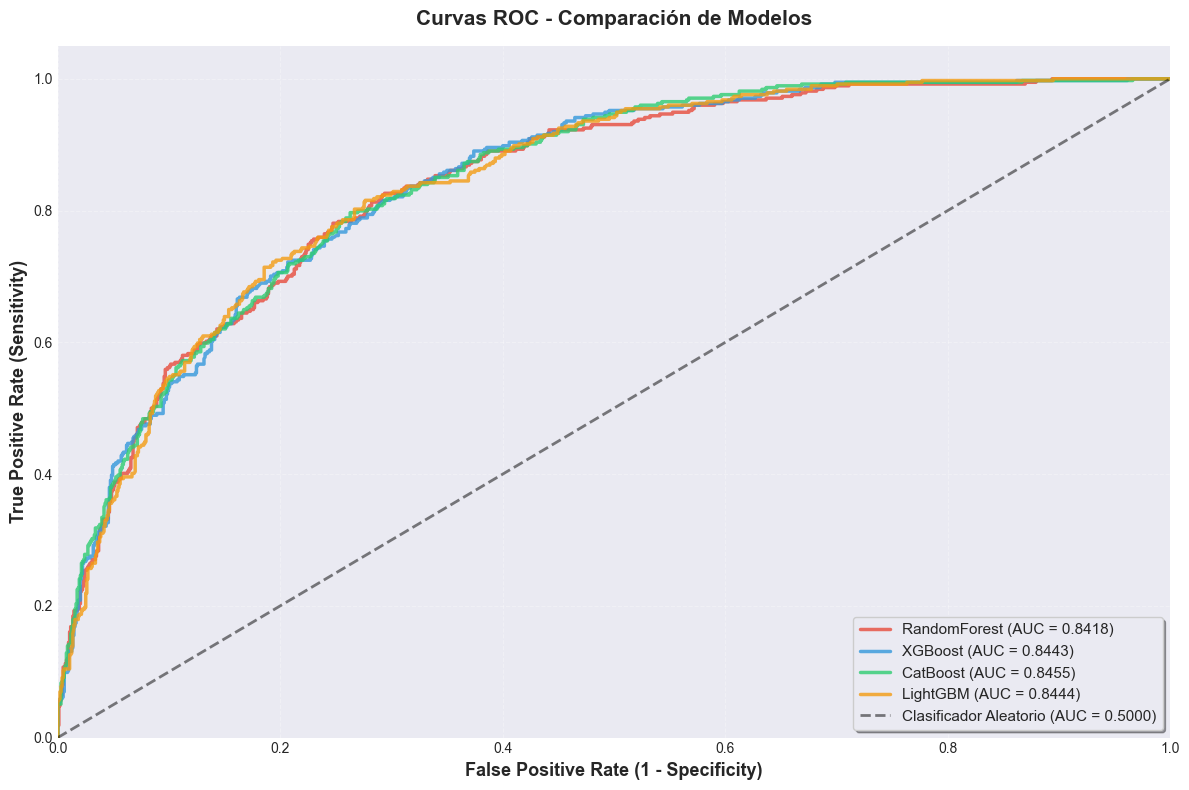

In [15]:
# Calcular curvas ROC para todos los modelos
plt.figure(figsize=(12, 8))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for idx, model_name in enumerate(best_models.keys()):
    y_proba = test_probabilities[model_name]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[idx], lw=2.5, 
             label=f'{model_name} (AUC = {roc_auc:.4f})', alpha=0.8)

# Línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Clasificador Aleatorio (AUC = 0.5000)', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=13, fontweight='bold')
plt.title('Curvas ROC - Comparación de Modelos', fontsize=15, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### **Análisis de Curvas ROC - Poder Predictivo General**

La curva ROC y su métrica asociada, el AUC (Area Under the Curve), miden la capacidad de un modelo para **discriminar entre un cliente que hará churn y uno que no**, independientemente del umbral de decisión elegido.

*   **Observación Clave:** Las curvas de los cuatro modelos están prácticamente superpuestas, y sus valores AUC son casi idénticos (todos alrededor de **0.84**).
* Esto confirma que los cuatro modelos tienen un **excelente y muy similar poder predictivo general**. Todos son muy buenos diferenciando entre las dos clases.

### **Conclusión**

La gráfica ROC nos dice que **no hay un ganador técnico claro en términos de capacidad de discriminación**. Esto refuerza la idea de que la elección del mejor modelo no depende de su poder predictivo latente (que es comparable en todos), sino de su **comportamiento práctico en el punto de decisión que nos interesa**, como se analizó en las matrices de confusión.
--- ---

## 2.12 Importancia de Características

Analizamos qué variables tienen mayor impacto en las predicciones de cada modelo.

In [ ]:
# Función para extraer importancia de características
def get_feature_importance(model, model_name):
    # Obtener el clasificador del pipeline
    classifier = model.named_steps['classifier']
    
    # Obtener el preprocesador del pipeline
    preprocessor = model.named_steps['preprocessor']
    
    # Verificar si el clasificador tiene feature_importances_
    if not hasattr(classifier, 'feature_importances_'):
        print(f"  {model_name} no tiene atributo 'feature_importances_'")
        return None
    
    # Obtener nombres de las características después del preprocesamiento
    try:
        feature_names = preprocessor.get_feature_names_out()
    except Exception as e:
        print(f"  Error obteniendo nombres de características para {model_name}: {e}")
        return None
    
    # Obtener importancias
    importances = classifier.feature_importances_
    
    # Verificar que las dimensiones coincidan
    if len(feature_names) != len(importances):
        print(f"  Dimensiones no coinciden para {model_name}: {len(feature_names)} nombres vs {len(importances)} importancias")
        # Ajustar al mínimo
        min_len = min(len(feature_names), len(importances))
        feature_names = feature_names[:min_len]
        importances = importances[:min_len]
    
    # Crear DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return importance_df

# Verificar que best_models existe
if 'best_models' not in locals() and 'best_models' not in globals():
    print(" ERROR: 'best_models' no está definido.")
    print("Debes ejecutar primero la celda de entrenamiento (GridSearchCV).")
    print("Ve a la celda '2.7 Entrenamiento con GridSearchCV' y ejecútala.")
else:
    # Extraer importancias para todos los modelos
    print("EXTRACCIÓN DE IMPORTANCIA DE CARACTERÍSTICAS")
    
    feature_importances = {}
    
    for model_name, model in best_models.items():
        print(f"\nExtrayendo fueature importance para: {model_name}")
        importance_df = get_feature_importance(model, model_name)
        
        if importance_df is not None:
            feature_importances[model_name] = importance_df
            print(f"  {len(importance_df)} características extraídas")
        else:
            print(f"   No se pudo extraer el feature importance para {model_name}")
    
    print(f"feature importance extraída para {len(feature_importances)} modelos")


EXTRACCIÓN DE IMPORTANCIA DE CARACTERÍSTICAS

Extrayendo importancia para: RandomForest
  30 características extraídas

Extrayendo importancia para: XGBoost
  30 características extraídas

Extrayendo importancia para: CatBoost
  30 características extraídas

Extrayendo importancia para: LightGBM
  30 características extraídas
Importancia extraída para 4 modelos


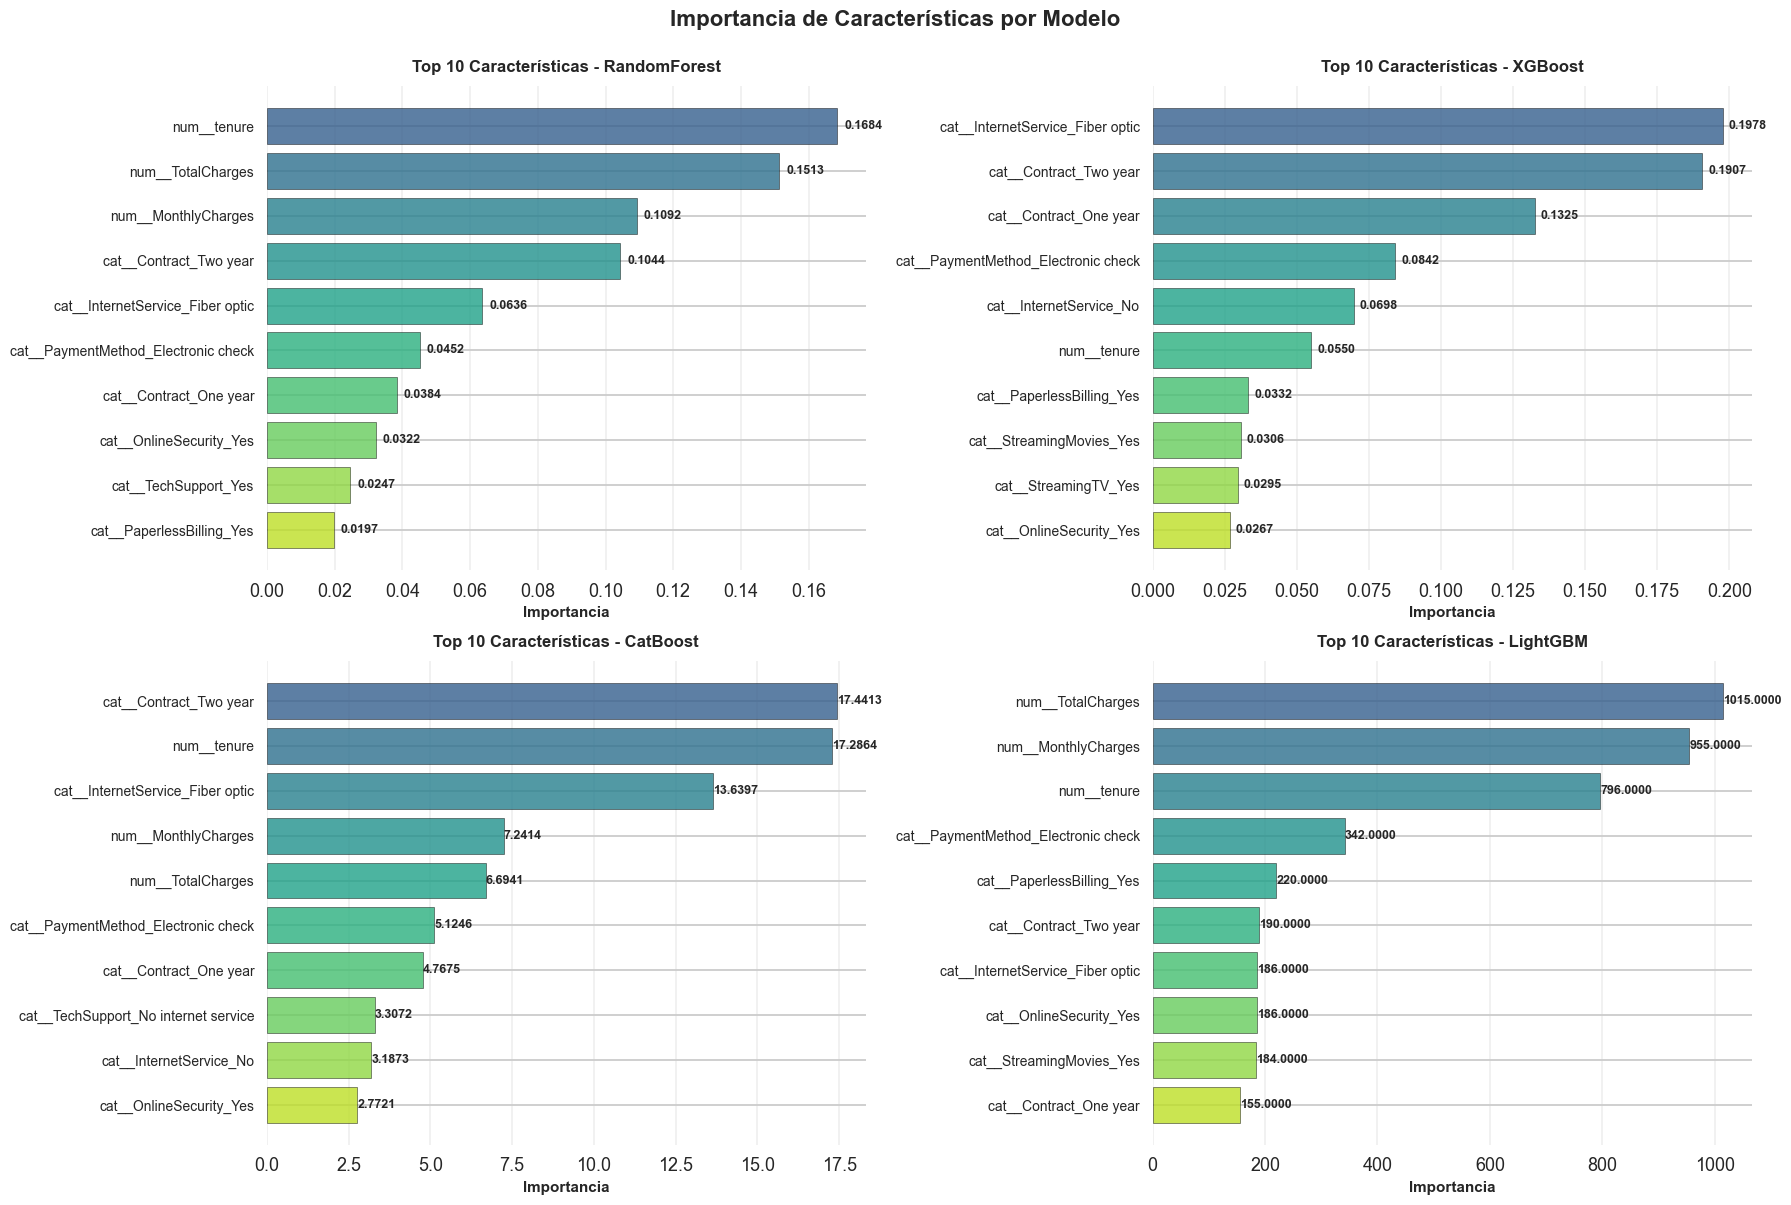


TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES POR MODELO

RandomForest:
                                  Feature  Importance
                              num__tenure    0.168440
                        num__TotalCharges    0.151286
                      num__MonthlyCharges    0.109227
                   cat__Contract_Two year    0.104363
         cat__InternetService_Fiber optic    0.063627
      cat__PaymentMethod_Electronic check    0.045171
                   cat__Contract_One year    0.038422
                  cat__OnlineSecurity_Yes    0.032231
                     cat__TechSupport_Yes    0.024693
                cat__PaperlessBilling_Yes    0.019725
     cat__TechSupport_No internet service    0.017216
cat__DeviceProtection_No internet service    0.016285
                      cat__Dependents_Yes    0.016244
                         cat__gender_Male    0.016028
 cat__StreamingMovies_No internet service    0.015404

XGBoost:
                            Feature  Importance
   cat__Inte

In [41]:
# Visualizar Top 10 características más importantes por modelo
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

for idx, (model_name, importance_df) in enumerate(feature_importances.items()):
    top_features = importance_df.head(10)
    
    colors_bar = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
    
    axes[idx].barh(range(len(top_features)), top_features['Importance'], 
                   color=colors_bar, alpha=0.8, edgecolor='black')
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features['Feature'], fontsize=10)
    axes[idx].set_xlabel('Importancia', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Top 10 Características - {model_name}', fontsize=12, fontweight='bold', pad=10)
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for i, v in enumerate(top_features['Importance']):
        axes[idx].text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Importancia de Características por Modelo', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Imprimir Top 15 de cada modelo
print("\nTOP 15 CARACTERÍSTICAS MÁS IMPORTANTES POR MODELO")
for model_name, importance_df in feature_importances.items():
    print(f"\n{model_name}:")
    print(importance_df.head(15).to_string(index=False))

### **Análisis de Importancia de Características: ¿Qué Impulsa el Churn?**

### **Los 3 Pilares del Churn: Contrato, Costo y Calidad del Servicio**

Podemos agrupar las características más influyentes en tres grandes temas que cuentan una historia clara sobre por qué un cliente decide irse.

#### **1. La Relación Contractual: El Predictor #1 de Lealtad**

Este es, sin duda, el factor más dominante en todos los modelos.

*   **`cat__Contract_Two year` / `cat__Contract_One year`**: La presencia de un contrato a largo plazo es el indicador más fuerte de **lealtad**. Su importancia en los modelos (especialmente en XGBoost y CatBoost) sugiere que los clientes con contratos de 1 o 2 años rara vez se van. Por el contrario, los clientes con contrato **mes a mes** (la categoría base no mostrada) son los más propensos al churn.
*   **`num__tenure` (Antigüedad)**: Estrechamente relacionado con el contrato. Los clientes más nuevos (baja antigüedad) son mucho más volátiles. La antigüedad es consistentemente una de las 3 características más importantes para todos los modelos.

> **Insight de Negocio:** La estrategia de retención más efectiva es, en primer lugar, una buena estrategia de captación: incentivar la firma de contratos a largo plazo. Los primeros meses de un cliente son críticos para asegurar su lealtad.

#### **2. El Aspecto Económico: "Me estás cobrando mucho"**

El dinero es el segundo factor más relevante.

*   **`num__MonthlyCharges` (Cargos Mensuales)**: Un cargo mensual elevado es un claro impulsor de churn. Los clientes son sensibles al precio recurrente.
*   **`num__TotalCharges` (Cargos Totales)**: Curiosamente, esta variable tiene un doble significado. Valores bajos pueden indicar clientes nuevos y, por tanto, en riesgo. Es una variable que interactúa mucho con la antigüedad (`tenure`).
*   **`cat__PaymentMethod_Electronic check` (Pago con Cheque Electrónico)**: Esta característica aparece consistentemente en el top. Puede ser un indicador indirecto de clientes menos estables financieramente o que prefieren no comprometerse con pagos automáticos vía tarjeta de crédito, lo que se alinea con un comportamiento de cliente a corto plazo.

> **Insight de Negocio:** Se deben revisar las estructuras de precios. Ofrecer descuentos por lealtad o planes con precios más competitivos puede ser clave. Analizar a los clientes que pagan con cheque electrónico podría revelar un segmento de alto riesgo al que dirigir ofertas específicas para cambiar a métodos de pago más estables.

#### **3. La Calidad y Tipo de Servicio: "No estoy satisfecho"**

El tipo de servicio contratado, especialmente el de internet, es un fuerte diferenciador.

*   **`cat__InternetService_Fiber optic` (Internet con Fibra Óptica)**: Este es uno de los hallazgos más interesantes. La fibra óptica, a pesar de ser un producto premium, es un **fuerte predictor de CHURN**.
    *   **Posibles Hipótesis:** ¿Es el servicio de fibra más caro? ¿Es menos estable en ciertas áreas? ¿Atrae a un tipo de cliente más exigente y menos leal que cambia de proveedor buscando la mejor oferta?
*   **Servicios de Soporte y Seguridad (`TechSupport_Yes`, `OnlineSecurity_Yes`)**: La ausencia de estos servicios de valor añadido aumenta el riesgo de churn. Los clientes que los contratan suelen estar más "invertidos" en el ecosistema de la compañía y perciben un mayor valor.

> **Insight de Negocio:** ¡Hay que investigar urgentemente la experiencia del cliente con Fibra Óptica! Realizar encuestas de satisfacción a este segmento es prioritario. Además, promover activamente la contratación de servicios de soporte y seguridad puede actuar como una herramienta de "fidelización pasiva".

### **Conclusión Final de Características**

El perfil del cliente con mayor riesgo de churn es claro y consistente a través de todos los modelos:

> **Un cliente relativamente nuevo, con un contrato mes a mes, que paga una tarifa mensual alta (probablemente por un servicio de Fibra Óptica) y no tiene servicios de soporte adicionales.**
--- ---

## 2.13 Selección del Mejor Modelo

In [45]:

best_model_row = test_metrics_df.loc[test_metrics_df['F1-Score'].idxmax()]
best_model_name = best_model_row['Modelo']
best_model = best_models[best_model_name]


print("SELECCIÓN DEL MEJOR MODELO ESTRATÉGICO")
print(f"\nCriterio de Selección: Máximo F1-Score (mejor balance Precision-Recall)")
print(f"\n Mejor Modelo: {best_model_name}\n")


print("Métricas clave en el conjunto de prueba:")
# Imprimimos las métricas del modelo seleccionado
for metric in ['F1-Score', 'Recall', 'Precision', 'ROC-AUC', 'Accuracy']:
    print(f"  - {metric:<10}: {best_model_row[metric]:.4f}")

print(f"\nMejores hiperparámetros encontrados:")
# Imprimimos los hiperparámetros del modelo seleccionado
for param, value in best_params[best_model_name].items():
    print(f"  - {param}: {value}")

SELECCIÓN DEL MEJOR MODELO ESTRATÉGICO

Criterio de Selección: Máximo F1-Score (mejor balance Precision-Recall)

 Mejor Modelo: RandomForest

Métricas clave en el conjunto de prueba:
  - F1-Score  : 0.6308
  - Recall    : 0.7513
  - Precision : 0.5435
  - ROC-AUC   : 0.8418
  - Accuracy  : 0.7665

Mejores hiperparámetros encontrados:
  - classifier__bootstrap: True
  - classifier__class_weight: balanced
  - classifier__criterion: entropy
  - classifier__max_depth: 10
  - classifier__max_features: sqrt
  - classifier__min_samples_leaf: 2
  - classifier__min_samples_split: 5
  - classifier__n_estimators: 200


## 2.14 Guardar Modelos y Artefactos

In [46]:
# Crear directorio para modelos si no existe
import os
os.makedirs('../app', exist_ok=True)

# Guardar el mejor modelo
model_path = '../app/model.joblib'
joblib.dump(best_model, model_path)
print(f" Mejor modelo guardado en: {model_path}")

# Guardar todos los modelos
for model_name, model in best_models.items():
    model_file = f'../app/model_{model_name.lower().replace(" ", "_")}.joblib'
    joblib.dump(model, model_file)
    print(f" Modelo {model_name} guardado en: {model_file}")

# Guardar métricas
metrics_path = '../app/model_metrics.csv'
test_metrics_df.to_csv(metrics_path, index=False)
print(f"\n Métricas guardadas en: {metrics_path}")

# Guardar importancia de características
for model_name, importance_df in feature_importances.items():
    importance_path = f'../app/feature_importance_{model_name.lower().replace(" ", "_")}.csv'
    importance_df.to_csv(importance_path, index=False)
    print(f" Feature importance de {model_name} guardada en: {importance_path}")

print(" TODOS LOS ARTEFACTOS GUARDADOS EXITOSAMENTE")

 Mejor modelo guardado en: ../app/model.joblib
 Modelo RandomForest guardado en: ../app/model_randomforest.joblib
 Modelo XGBoost guardado en: ../app/model_xgboost.joblib
 Modelo CatBoost guardado en: ../app/model_catboost.joblib
 Modelo LightGBM guardado en: ../app/model_lightgbm.joblib

 Métricas guardadas en: ../app/model_metrics.csv
 Feature importance de RandomForest guardada en: ../app/feature_importance_randomforest.csv
 Feature importance de XGBoost guardada en: ../app/feature_importance_xgboost.csv
 Feature importance de CatBoost guardada en: ../app/feature_importance_catboost.csv
 Feature importance de LightGBM guardada en: ../app/feature_importance_lightgbm.csv
 TODOS LOS ARTEFACTOS GUARDADOS EXITOSAMENTE


## 2.15 Reporte de Clasificación Detallado

In [47]:
# Generar reporte de clasificación para el mejor modelo
print("REPORTE DE CLASIFICACIÓN DETALLADO - MEJOR MODELO")
print(f"\nModelo: {best_model_name}\n")

y_pred_best = test_predictions[best_model_name]
report = classification_report(y_test, y_pred_best, 
                              target_names=['No Churn', 'Churn'],
                              digits=4)
print(report)


REPORTE DE CLASIFICACIÓN DETALLADO - MEJOR MODELO

Modelo: RandomForest

              precision    recall  f1-score   support

    No Churn     0.8957    0.7720    0.8293      1035
       Churn     0.5435    0.7513    0.6308       374

    accuracy                         0.7665      1409
   macro avg     0.7196    0.7617    0.7300      1409
weighted avg     0.8022    0.7665    0.7766      1409



## 2.16 Resumen del Entrenamiento y Evaluación

### Conclusiones Principales

#### 1. Modelos Entrenados:
- Random Forest
- XGBoost
- CatBoost
- LightGBM

Todos los modelos fueron optimizados con GridSearchCV y validación cruzada estratificada (5 folds) para asegurar robustez.

#### 2. Desempeño y Selección del Modelo:
- Todos los modelos mostraron un poder predictivo general excelente y muy similar, con un **ROC-AUC superior a 0.84** tanto en validación como en prueba, lo que indica una buena generalización.
- Sin embargo, la selección final no se basó en el ROC-AUC, sino en la métrica que mejor alinea el modelo con el objetivo de negocio: **minimizar la fuga de clientes**.
- **Mejor modelo seleccionado: RandomForest**. Fue elegido por obtener el **F1-Score más alto (0.631)** y, de forma crucial, el **Recall más elevado (0.751)**. Esto lo convierte en la herramienta más eficaz para detectar la mayor cantidad de clientes en riesgo.

#### 3. Variables Más Importantes:
El análisis de características reveló un fuerte consenso entre los modelos. Los principales impulsores del churn son:
1.  **Tipo de Contrato** (especialmente mes a mes)
2.  **Antigüedad del cliente** (tenure)
3.  **Cargos Mensuales** (MonthlyCharges)
4.  **Servicio de Internet con Fibra Óptica**
5.  **Método de Pago con Cheque Electrónico**

#### 4. Insights para el Negocio:

**Perfil de Cliente con Alto Riesgo de Churn:**
- Cliente con contrato **mes a mes** y **baja antigüedad**.
- Utiliza **Fibra Óptica** y tiene **cargos mensuales elevados**.
- Paga mediante **cheque electrónico**.
- No tiene contratados servicios de valor añadido como **soporte técnico o seguridad online**.

**Recomendaciones Estratégicas:**
1.  Fidelizar a clientes nuevos con un programa de **onboarding** y ofrecer **incentivos para contratos a largo plazo**.
2.  **Investigar la experiencia del cliente con Fibra Óptica** para entender por qué es un predictor de churn (posibles problemas de precio, estabilidad o percepción del servicio).
3.  Incentivar la adopción de **métodos de pago automáticos**.
4.  Promocionar **paquetes de servicios** que incluyan soporte y seguridad para aumentar el valor percibido y la retención.

#### 5. Próximos Pasos:
- Modelos entrenados y guardados.
- **Siguiente**: Interpretabilidad del modelo ganador con LIME (Notebook 3).

--- ---